In [1]:
!pip install scikit-learn
!pip install tensorflow
!pip install flask
!pip install flask-cors

## Data Preparation

In [2]:
import pandas as pd
import numpy as np

import string
import re
import nltk
from nltk import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import gensim
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import itertools

import pickle
from flask import Flask, request, render_template_string
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kylew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kylew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
real_ds = pd.read_csv("datasets/True.csv")
fake_ds = pd.read_csv("datasets/Fake.csv")

In [4]:
real_ds.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [5]:
real_ds.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
fake_ds.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [7]:
fake_ds.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
real_ds["category"] = 1
fake_ds["category"] = 0

In [9]:
real_ds.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
fake_ds.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [11]:
news_ds = pd.concat([real_ds, fake_ds], ignore_index=True, sort=False)

In [12]:
news_ds.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [13]:
news_ds.tail()

,title,text,subject,date,category
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [14]:
news_ds["category"].value_counts()

category
0    23481
1    21417
Name: count, dtype: int64

In [15]:
news_ds.iloc[0]['text']

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

## NLP Processing

In [16]:
def remove_punct(text):
    no_punct_text = []

    for char in text:
        if char not in set(string.punctuation):
            no_punct_text.append(char)
    new_string = "".join(no_punct_text)
    
    return new_string

In [17]:
processed_text = []
for text in news_ds["text"]:
    new_text = remove_punct(text)
    processed_text.append(new_text)

news_ds["PT"] = processed_text

In [18]:
news_ds.head()

,title,text,subject,date,category,PT
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The head of a conservative...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON Reuters Transgender people will be...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The special counsel invest...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON Reuters Trump campaign adviser Geo...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLEWASHINGTON Reuters President Donald Tr...


In [19]:
news_ds.tail()

,title,text,subject,date,category,PT
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,21st Century Wire says As 21WIRE reported earl...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,21st Century Wire says It s a familiar theme W...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,Patrick Henningsen 21st Century WireRemember ...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,21st Century Wire says Al Jazeera America will...
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0,21st Century Wire says As 21WIRE predicted in ...


In [20]:
def tokenize(text):
    tokens = re.split('\s+', text)
    tokens = [token.lower() for token in tokens]
    return tokens

In [21]:
tokens = []
for text in news_ds["PT"]:
    row_token = tokenize(text)
    tokens.append(row_token)
news_ds['tokens'] = tokens

In [22]:
news_ds.head()

,title,text,subject,date,category,PT,tokens
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The head of a conservative...,"[washington, reuters, the, head, of, a, conser..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON Reuters Transgender people will be...,"[washington, reuters, transgender, people, wil..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The special counsel invest...,"[washington, reuters, the, special, counsel, i..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON Reuters Trump campaign adviser Geo...,"[washington, reuters, trump, campaign, adviser..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLEWASHINGTON Reuters President Donald Tr...,"[seattlewashington, reuters, president, donald..."


In [23]:
news_ds.iloc[0]['tokens']

['washington',
 'reuters',
 'the',
 'head',
 'of',
 'a',
 'conservative',
 'republican',
 'faction',
 'in',
 'the',
 'us',
 'congress',
 'who',
 'voted',
 'this',
 'month',
 'for',
 'a',
 'huge',
 'expansion',
 'of',
 'the',
 'national',
 'debt',
 'to',
 'pay',
 'for',
 'tax',
 'cuts',
 'called',
 'himself',
 'a',
 '“fiscal',
 'conservative”',
 'on',
 'sunday',
 'and',
 'urged',
 'budget',
 'restraint',
 'in',
 '2018',
 'in',
 'keeping',
 'with',
 'a',
 'sharp',
 'pivot',
 'under',
 'way',
 'among',
 'republicans',
 'us',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'on',
 'cbs’',
 '“face',
 'the',
 'nation”',
 'drew',
 'a',
 'hard',
 'line',
 'on',
 'federal',
 'spending',
 'which',
 'lawmakers',
 'are',
 'bracing',
 'to',
 'do',
 'battle',
 'over',
 'in',
 'january',
 'when',
 'they',
 'return',
 'from',
 'the',
 'holidays',
 'on',
 'wednesday',
 'lawmakers',
 'will',
 'begin',
 'trying',
 'to',
 'pass',
 'a',
 'federal',
 'budget',
 'in',
 'a',
 'fight',
 'likely',
 'to',
 

In [24]:
def remove_small_words(tokens):
    filtered_tokens = []
    for token in tokens:
        if len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

In [25]:
filtered_texts = []
for tokens in news_ds['tokens']:
    filtered_tokens = remove_small_words(tokens)
    filtered_texts.append(filtered_tokens)
news_ds['new_tokens'] = filtered_texts

In [26]:
news_ds.head()

,title,text,subject,date,category,PT,tokens,new_tokens
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The head of a conservative...,"[washington, reuters, the, head, of, a, conser...","[washington, reuters, the, head, conservative,..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON Reuters Transgender people will be...,"[washington, reuters, transgender, people, wil...","[washington, reuters, transgender, people, wil..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The special counsel invest...,"[washington, reuters, the, special, counsel, i...","[washington, reuters, the, special, counsel, i..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON Reuters Trump campaign adviser Geo...,"[washington, reuters, trump, campaign, adviser...","[washington, reuters, trump, campaign, adviser..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLEWASHINGTON Reuters President Donald Tr...,"[seattlewashington, reuters, president, donald...","[seattlewashington, reuters, president, donald..."


In [27]:
news_ds.iloc[0]['new_tokens']

['washington',
 'reuters',
 'the',
 'head',
 'conservative',
 'republican',
 'faction',
 'the',
 'congress',
 'who',
 'voted',
 'this',
 'month',
 'for',
 'huge',
 'expansion',
 'the',
 'national',
 'debt',
 'pay',
 'for',
 'tax',
 'cuts',
 'called',
 'himself',
 '“fiscal',
 'conservative”',
 'sunday',
 'and',
 'urged',
 'budget',
 'restraint',
 '2018',
 'keeping',
 'with',
 'sharp',
 'pivot',
 'under',
 'way',
 'among',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'cbs’',
 '“face',
 'the',
 'nation”',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'which',
 'lawmakers',
 'are',
 'bracing',
 'battle',
 'over',
 'january',
 'when',
 'they',
 'return',
 'from',
 'the',
 'holidays',
 'wednesday',
 'lawmakers',
 'will',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'other',
 'issues',
 'such',
 'immigration',
 'policy',
 'even',
 'the',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'which',
 'r

In [28]:
def remove_stopwords(tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))

    noStopW_tokens = []
    for token in tokens:
        if token not in stopwords:
            noStopW_tokens.append(token)
    return noStopW_tokens

In [29]:
noStopW_texts = []
for tokens in news_ds['new_tokens']:
    noStopW_tokens = remove_stopwords(tokens)
    noStopW_texts.append(noStopW_tokens)
news_ds['new_tokens'] = noStopW_texts

In [30]:
news_ds.head()

,title,text,subject,date,category,PT,tokens,new_tokens
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The head of a conservative...,"[washington, reuters, the, head, of, a, conser...","[washington, reuters, head, conservative, repu..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON Reuters Transgender people will be...,"[washington, reuters, transgender, people, wil...","[washington, reuters, transgender, people, all..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The special counsel invest...,"[washington, reuters, the, special, counsel, i...","[washington, reuters, special, counsel, invest..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON Reuters Trump campaign adviser Geo...,"[washington, reuters, trump, campaign, adviser...","[washington, reuters, trump, campaign, adviser..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLEWASHINGTON Reuters President Donald Tr...,"[seattlewashington, reuters, president, donald...","[seattlewashington, reuters, president, donald..."


In [31]:
news_ds.iloc[0]['new_tokens']

['washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay',
 'tax',
 'cuts',
 'called',
 '“fiscal',
 'conservative”',
 'sunday',
 'urged',
 'budget',
 'restraint',
 '2018',
 'keeping',
 'sharp',
 'pivot',
 'way',
 'among',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'cbs’',
 '“face',
 'nation”',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'even',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'keep',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'big',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'also',
 'want',
 'prop

In [32]:
def lemmatization(tokens):
    wnLem = WordNetLemmatizer()
    lemmatized_tokens = []
    
    for token in tokens:
        lemmatized_token = wnLem.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)
    
    return lemmatized_tokens

In [33]:
lemmatized_texts = []
for tokens in news_ds['new_tokens']:
    lemmatized_tokens = lemmatization(tokens)
    lemmatized_texts.append(lemmatized_tokens)
news_ds['new_tokens'] = lemmatized_texts

In [34]:
news_ds.iloc[0]['new_tokens']

['washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'pay',
 'tax',
 'cut',
 'called',
 '“fiscal',
 'conservative”',
 'sunday',
 'urged',
 'budget',
 'restraint',
 '2018',
 'keeping',
 'sharp',
 'pivot',
 'way',
 'among',
 'republican',
 'representative',
 'mark',
 'meadow',
 'speaking',
 'cbs’',
 '“face',
 'nation”',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmaker',
 'bracing',
 'battle',
 'january',
 'return',
 'holiday',
 'wednesday',
 'lawmaker',
 'begin',
 'trying',
 'pas',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issue',
 'immigration',
 'policy',
 'even',
 'november',
 'congressional',
 'election',
 'campaign',
 'approach',
 'republican',
 'seek',
 'keep',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republican',
 'want',
 'big',
 'budget',
 'increase',
 'military',
 'spending',
 'democrat',
 'also',
 'want',
 'proportional',
 

In [35]:
def join_tokens(tokens):
    return " ".join(tokens)

In [36]:
news_ds['new_tokens'] = news_ds['new_tokens'].apply(join_tokens)

In [37]:
news_ds.head()

,title,text,subject,date,category,PT,tokens,new_tokens
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The head of a conservative...,"[washington, reuters, the, head, of, a, conser...",washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,WASHINGTON Reuters Transgender people will be...,"[washington, reuters, transgender, people, wil...",washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,WASHINGTON Reuters The special counsel invest...,"[washington, reuters, the, special, counsel, i...",washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,WASHINGTON Reuters Trump campaign adviser Geo...,"[washington, reuters, trump, campaign, adviser...",washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,SEATTLEWASHINGTON Reuters President Donald Tr...,"[seattlewashington, reuters, president, donald...",seattlewashington reuters president donald tru...


In [38]:
news_ds.iloc[0]['new_tokens']

'washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called “fiscal conservative” sunday urged budget restraint 2018 keeping sharp pivot way among republican representative mark meadow speaking cbs’ “face nation” drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense “discretionary” spending program support education scientific research infrastructure public health environmental protection “the trump administration already willing say ‘we’re going increase nondefense discretionary spending percent’” meadow chairman small influential house freedom caucus said program “now democrat sayin

## Baseline Model

In [39]:
train_x, test_x, train_y, test_y = train_test_split(news_ds['new_tokens'], news_ds['category'], test_size=0.2, random_state=22)

tfidf_vector = TfidfVectorizer()

train_x = tfidf_vector.fit_transform(train_x)
test_x = tfidf_vector.transform(test_x)

print(train_x.shape)
print(test_x.shape)

(35918, 196049)
(8980, 196049)


### Logistic Regression Model

In [40]:
lr_model = LogisticRegression()
lr_model.fit(train_x, train_y)

lr_pred = lr_model.predict(test_x)

lr_acc = accuracy_score(test_y, lr_pred)
lr_cm = confusion_matrix(test_y, lr_pred)

print("Logistic Regression Model Stats:")
print("Accuracy: {}".format(lr_acc))
print("Confusion matrix:\n{}".format(lr_cm))

Logistic Regression Model Stats:
Accuracy: 0.9903118040089087
Confusion matrix:
[[4619   57]
 [  30 4274]]


In [41]:
print(classification_report(test_y, lr_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4676
           1       0.99      0.99      0.99      4304

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Decision Tree Model

In [42]:
dt_model = DecisionTreeClassifier()
dt_model.fit(train_x, train_y)

dt_pred  = dt_model.predict(test_x)

dt_acc  = accuracy_score(test_y, dt_pred)
dt_cm  = confusion_matrix(test_y, dt_pred)

print("Decision Tree Model Stats:")
print("Accuracy: {}".format(dt_acc))
print("Confusion matrix:\n{}".format(dt_cm))

Decision Tree Model Stats:
Accuracy: 0.9973273942093541
Confusion matrix:
[[4664   12]
 [  12 4292]]


In [43]:
print(classification_report(test_y, dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4676
           1       1.00      1.00      1.00      4304

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Random Forest Model

In [44]:
rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

rf_pred  = rf_model.predict(test_x)

rf_acc  = accuracy_score(test_y, rf_pred)
rf_cm  = confusion_matrix(test_y, rf_pred)

print("Random Forest Model Stats:")
print("Accuracy: {}".format(rf_acc))
print("Confusion matrix:\n{}".format(rf_cm))

Random Forest Model Stats:
Accuracy: 0.9944320712694877
Confusion matrix:
[[4640   36]
 [  14 4290]]


In [45]:
print(classification_report(test_y, rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4676
           1       0.99      1.00      0.99      4304

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Baseline Model Comparison

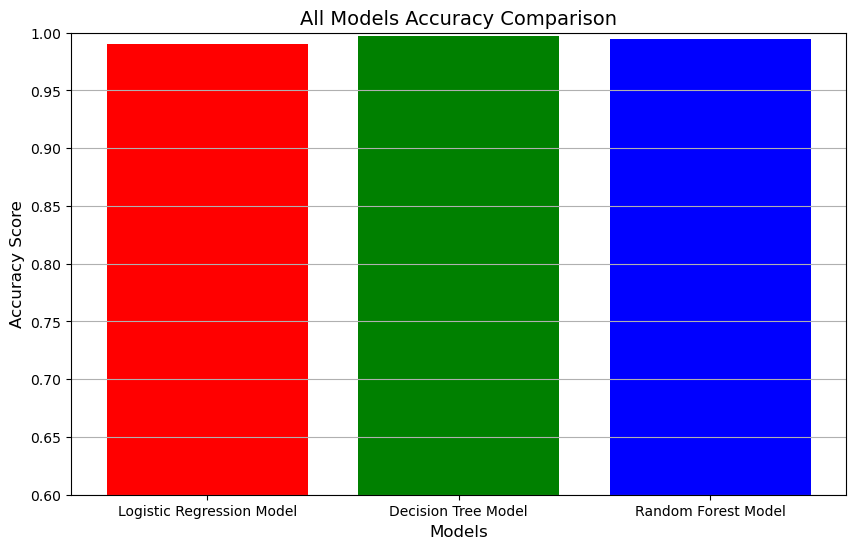

In [46]:
all_models = ['Logistic Regression Model', 'Decision Tree Model', 'Random Forest Model']
all_acc = [lr_acc, dt_acc, rf_acc]

plt.figure(figsize=(10, 6))
plt.bar(all_models, all_acc, color=['red', 'green', 'blue'])
plt.title('All Models Accuracy Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.ylim(0.60, 1.00)
plt.grid(axis='y')
plt.show()

### Baseline Model Comparison Text

## Deep Learning Model 

In [47]:
dl_train, dl_test = train_test_split(news_ds, test_size=0.2, random_state=20)

### Word2Vec

In [48]:
w2v_size = 300
w2v_window = 7
w2v_mincount = 10

word2vec_model = gensim.models.word2vec.Word2Vec(vector_size=w2v_size, window=w2v_window, min_count=w2v_mincount, workers=8)

In [49]:
documents = [_text.split() for _text in dl_train.text] 

word2vec_model.build_vocab(documents)

words = list(word2vec_model.wv.index_to_key)
print("Word list size:", len(words))

Word list size: 48901


In [50]:
epoch_count = 32

word2vec_model.train(documents, total_examples=len(documents), epochs=epoch_count)

(356825958, 466232032)

### Tokenization

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dl_train.text)

vocab_size = len(tokenizer.word_index) + 1

print("Total words", vocab_size)

Total words 125389


In [52]:
x_train = pad_sequences(tokenizer.texts_to_sequences(dl_train.text), maxlen=300)

x_test = pad_sequences(tokenizer.texts_to_sequences(dl_test.text), maxlen=300)

### Label Encoding

In [53]:
label_encoder = LabelEncoder()
label_encoder.fit(dl_train['category'].tolist())

y_train = label_encoder.transform(dl_train['category'].tolist())
y_test = label_encoder.transform(dl_test['category'].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

### Embedding Layer

In [54]:
em_matrix = np.zeros((vocab_size, w2v_size))

for word, i in tokenizer.word_index.items():
  if word in word2vec_model.wv:
    em_matrix[i] = word2vec_model.wv[word]
    
em_layer = Embedding(vocab_size, w2v_size, weights=[em_matrix], input_length=300, trainable=False)

C:\Users\kylew\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Tensorflow LSTM Model

In [55]:
LSTM_model = Sequential()
LSTM_model.add(em_layer)
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Bidirectional(LSTM(100, dropout=0.25, recurrent_dropout=0.25)))
LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    37,616,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,616,700 (143.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 37,616,700 (143.50 MB)

In [56]:
LSTM_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [57]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)]

In [58]:
history = LSTM_model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=epoch_count,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 861ms/step - accuracy: 0.7504 - loss: 0.5124 - val_accuracy: 0.9259 - val_loss: 0.2194 - learning_rate: 0.0010
Epoch 2/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 779ms/step - accuracy: 0.9192 - loss: 0.2054 - val_accuracy: 0.9496 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 3/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 799ms/step - accuracy: 0.9376 - loss: 0.1644 - val_accuracy: 0.9513 - val_loss: 0.1581 - learning_rate: 0.0010
Epoch 4/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 792ms/step - accuracy: 0.9526 - loss: 0.1337 - val_accuracy: 0.9577 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 5/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 785ms/step - accuracy: 0.9562 - loss: 0.1207 - val_accuracy: 0.9610 - val_loss: 0.1240 - learning_rate: 0.0010
Epoch 6/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 848ms/step - accuracy: 0.9617 - loss: 0.1092 - val_accuracy: 0.9663 - val_loss: 0.1103 - learning_rate: 0.0010
Epoch 7/32
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 805ms/step - accuracy: 0.9648 - loss: 0.

In [59]:
scores = LSTM_model.evaluate(x_test, y_test, batch_size=1024)

print("LSTM Model Accuracy:", scores[1])
print("LSTM Model Loss:", scores[0])

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.9801 - loss: 0.0588
LSTM Model Accuracy: 0.9816258549690247
LSTM Model Loss: 0.05439994856715202


### Confusion Matrix

In [60]:
pred_prob = LSTM_model.predict(x_test)

mid_pt = 0.5
pred = (pred_prob > mid_pt).astype(int)

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


In [61]:
y_pred_classes = np.argmax(pred_prob, axis=1) if pred_prob.shape[1] > 1 else (pred_prob > 0.5).astype("int32")

y_true = np.argmax(y_test, axis=1) if y_test.shape[1] > 1 else y_test

print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4696
           1       0.99      0.97      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [62]:
def cm_visual(cm, cat):
    
    n_cat = len(cat)
    cm = cm.reshape((n_cat, n_cat))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', fontsize=25)
    plt.colorbar()
    marks = np.arange(len(cat))
    plt.xticks(marks, cat, fontsize=20)
    plt.yticks(marks, cat, fontsize=20)
    
    cm_thresh = cm.max() / 2.
    for x, y in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(y, x, format(cm[x, y]),
                 horizontalalignment="center",
                 color="white" if cm[x, y] > cm_thresh else "black")

    plt.ylabel('Real Target', fontsize=20) 
    plt.xlabel('Predicted Target', fontsize=20)

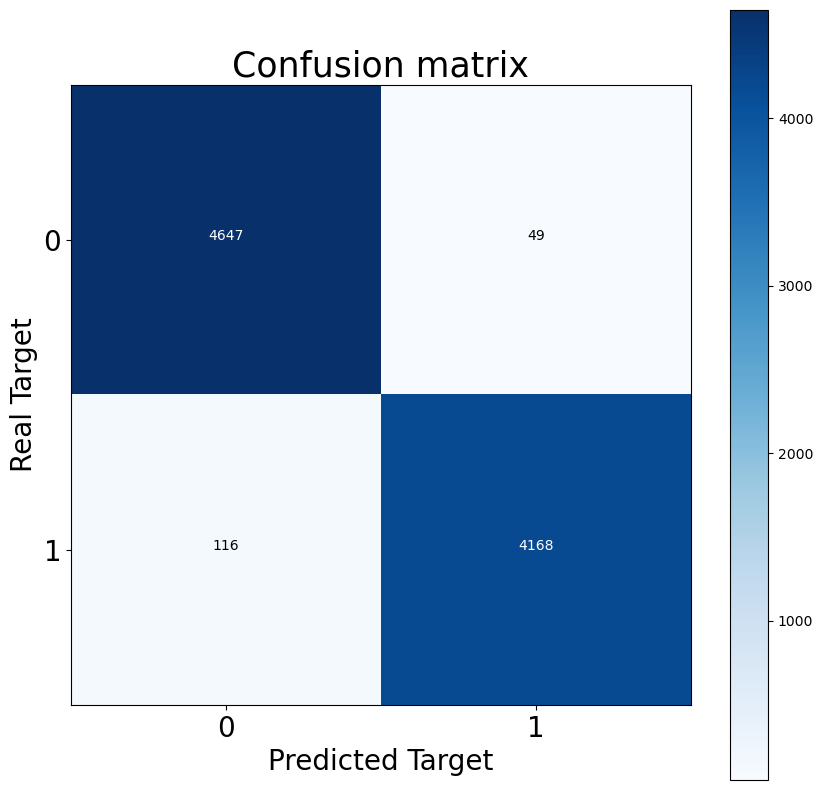

In [63]:
cnf_matrix = confusion_matrix(y_test, pred)

plt.figure(figsize=(10,10))

cm_visual(cnf_matrix, cat=dl_train['category'].unique())
plt.show()

In [64]:
tf_lstm_model = 'model.keras'
tf_tokenizer = 'tokenizer.pkl'
w2v_model = 'w2v_model.bin'

In [65]:
LSTM_model.save(tf_lstm_model)
pickle.dump(tokenizer, open(tf_tokenizer, "wb"), protocol=0)
word2vec_model.save(w2v_model)

## Fake News Detection Interface

In [66]:
def submit_article(text):
    rp_new_article = remove_punct(text)
    token_new_article = tokenize(rp_new_article)
    smallW_new_article = remove_small_words(token_new_article)
    stopW_new_article = remove_stopwords(smallW_new_article)
    lem_new_article = lemmatization(stopW_new_article)
    new_article_text = join_tokens(lem_new_article)

    word2vec_model = gensim.models.Word2Vec.load('w2v_model.bin')

    tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
    token_text = tokenizer.texts_to_sequences([new_article_text])

    padded_token_text = pad_sequences(token_text, maxlen=300)

    saved_lstm_model = load_model('model.keras')

    result = saved_lstm_model.predict(padded_token_text)

    return result

In [67]:
real_result = submit_article('WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trumpâ€™s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administrationâ€™s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. â€œThe Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DODâ€™s study and will continue to defend the presidentâ€™s lawful authority in District Court in the meantime,â€ the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: â€œAs mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.â€ Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal â€œgreat news.â€ â€œIâ€™m hoping it means the government has come to see that there is no way to justify a ban and that itâ€™s not good for the military or our country,â€ Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obamaâ€™s policy of accepting them. Trump said on Twitter at the time that the military â€œcannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.â€ Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trumpâ€™s ban while legal challenges to the Republican presidentâ€™s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicantsâ€™ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept â€œsome individuals who are not medically fit for service.â€ The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trumpâ€™s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the presidentâ€™s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity.')
print(real_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
[[0.9993147]]


In [68]:
fake_result = submit_article('Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.')
print(fake_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
[[0.00037476]]


In [70]:
app = Flask(__name__)

html_template = '''
<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <title>Fake News Detector</title>
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0-beta3/css/all.min.css">
    <style>
      body {
        display: flex;
        justify-content: center;
        align-items: center;
        text-align: center;
        min-height: 100vh;
        font-family: "Roboto", sans-serif;
        margin: 0;
        padding: 0;
      }
      
      section {
        width: 100%;
        max-width: 1000px;
        margin: auto;
      }

      .container {
        color: rgb(17, 14, 14);
        border-radius: 1rem;
        display: flex;
        justify-content: center;
        align-items: center;
        flex-direction: column;
        padding: 2rem;
        box-shadow: 0px 0px 5px 0px rgba(0, 0, 0, 0.75);
      }
      
      h1, h2 {
        margin-bottom: 20px;
      }

      form {
        display: flex;
        flex-direction: column;
        align-items: center;
        width: 100%;
      }

      textarea {
        width: 100%;
        height: 400px;
        margin-bottom: 20px;
        padding: 10px;
        font-size: 16px;
      }

      button {
        display: inline-block;
        font-size: 1em;
        font-weight: 700;
        color: black;
        padding: 10px;
        border-radius: 5px;
        cursor: pointer;
        transition: all 200ms ease-in-out;
      }
 
      button:hover { 
        background-color: yellow; 
      }
    </style>
  </head>
  <body>
    <section>
        <div class="container">
            <h1>Fake News Detector <i class="fas fa-info-circle" title="Enter the text you want to check in the box below and click Submit to get a prediction."></i></h1>
            <form action="/" method="post">
                <h2>Step 1: Insert Article Below</h2>
                <textarea name="text" rows="10" cols="50" placeholder="Paste your article here and click the Submit button..."></textarea><br>
                <h2>Step 2: Click Submit</h2>
                <button type="submit">Submit</button>
            </form>
            <h2>Step 3: Prediction Display Below</h2>
            <h2>Prediction: {{ prediction }}</h2>
        </div>
    </section>
  </body>
</html>
'''

@app.route('/', methods=['GET', 'POST'])
def home():
    prediction = ''
    if request.method == 'POST':
        text = request.form['text']
        if text:
            #print(text)
            #print(type(text))
            pred = submit_article(text)[0][0]
            if pred > 0.5:
                prediction = 'True'
            else:
                prediction = 'False'
        else:
            prediction = 'No text found'
    return render_template_string(html_template, prediction=prediction)

if __name__ == '__main__':
    app.run(host='localhost', port=4040)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:4040
Press CTRL+C to quit
